In [31]:
import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

from chainer.datasets import split_dataset_random

## Load MNIST dataset

In [32]:
from chainer.datasets import mnist

train_valid, test = mnist.get_mnist()

In [33]:
print("train_valid: %s" % type(train_valid))
print("test: %s" % type(test))

print("# of train_valid: %s" % len(train_valid))
print("# of test: %s" % len(test))

train_valid: <class 'chainer.datasets.tuple_dataset.TupleDataset'>
test: <class 'chainer.datasets.tuple_dataset.TupleDataset'>
# of train_valid: 60000
# of test: 10000


### Split the dataset

In [34]:
train, valid = split_dataset_random(train_valid, 50000, seed = 0)

In [35]:
print("# of training dataset: ",  len(train))
print("# of validation dataset: ", len(valid))
print("# of test dataset: ", len(test))

# of training dataset:  50000
# of validation dataset:  10000
# of test dataset:  10000


## Prepare iterators

In [36]:
batch_size = 128

train_iter = iterators.SerialIterator(train, batch_size)
valid_iter = iterators.SerialIterator(valid, batch_size, repeat=False, shuffle=False)
test_iter  = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

## Build the model

In [37]:
class LeNet5LikeNet(Chain):
    def __init__(self):
        super(LeNet5LikeNet, self).__init__()
        
        with self.init_scope():
            self.c1 = L.Convolution2D(1, 6, ksize=5, stride=1, pad=2)  # same padding      
            self.c3 = L.Convolution2D(6, 16, ksize=5, stride=1)
            self.c5 = L.Convolution2D(16, 120, ksize=5, stride=1)
            self.f6  = L.Linear(None, 84)
            self.out = L.Linear(84, 10)
    
    def __call__(self, x):
        X = F.reshape(x, (-1, 1, 28, 28))

        a1 = F.tanh(self.c1(X))                                # shape: (m, 6, 28, 28)
        a2 = F.max_pooling_2d(a1, 2, stride=2)  # shape: (m, 6, 14, 14)
        a3 = F.tanh(self.c3(a2))                              # shape: (m, 16, 10, 10)
        a4 = F.max_pooling_2d(a3, 2, stride=2)  # shape: (m, 16, 5, 5)
        a5 = F.tanh(self.c5(a4))                              # shape: (m, 120, 1, 1)
        a6 = F.tanh(self.f6(a5))                              # shape: (m, 84)
        out =self.out(a6)                                         # shape: (m, 10) 
        
        if chainer.config.train:
            return out

        return F.softmax(out)

In [38]:
x0, y0 = train[0]
model = LeNet5LikeNet()
print(type(model(x0)))

print(model(x0).shape)
print(model(x0))

<class 'chainer.variable.Variable'>
(1, 10)
variable([[-0.25595552  0.11348672  0.25362426 -0.02441835  0.20746998
           -0.00869421 -0.19679134  0.36703482 -0.06739937  0.15590465]])


## Create trainer

In [39]:
def create_trainer(model,  train_iter, valid_iter, max_epoch=10, gpu_id = -1):
    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    optimizer = optimizers.SGD()
    optimizer.setup(model)
    
    updater = training.updater.StandardUpdater(train_iter, optimizer, device=gpu_id)

    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='out/mnist')
    
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
    trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
    trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    return trainer

In [41]:
model = LeNet5LikeNet()
model = L.Classifier(model)

train_iter.reset()
valid_iter.reset()
test_iter.reset()

trainer = create_trainer(model, train_iter, valid_iter, max_epoch=10)
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.45257     0.636549       1.88146               0.829312                  31.6742       
2           0.57058     0.867567       1.71139               0.891515                  62.1012       
3           0.384417    0.901763       1.64569               0.910403                  92.3652       
4           0.303781    0.918159       1.61006               0.924051                  122.719       
5           0.253825    0.929767       1.58688               0.93483                   153.18        
6           0.21951     0.939123       1.57087               0.942445                  183.864       
7           0.193802    0.945552       1.55869               0.948972                  217.96        
8           0.174338    0.950401       1.54917               0.954114                  253.524       
9           0.158466    0.955483       1.54171               0.95718                

## Evaluate test set

In [67]:
gpu_id = -1

test_evaluator = extensions.Evaluator(test_iter, model, device=gpu_id)
results = test_evaluator()
print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.9641020569620253


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

<class 'numpy.ndarray'>
<class '__main__.ConvNet'>
[[0.06085572 0.04745439 0.3219122  0.1336315  0.0031591  0.14382526
  0.16701122 0.00335385 0.11508172 0.00371499]]
prediction: 2, acctual: 2


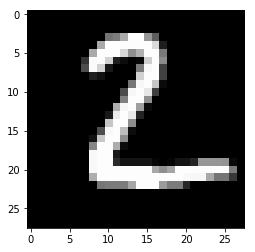

In [18]:
infer_net = LeNet5LikeNet()
serializers.load_npz(
    'out/snapshot_epoch-1',
    infer_net, path='updater/model:main/predictor/')


with chainer.using_config('train', False):
    test_x, test_label = test[1]
    print(type(test_x))
    print(type(infer_net))
    pred = infer_net(test_x).data
    pred_label = pred.argmax(axis=1)

    print(pred)

    print("prediction: {}, acctual: {}".format(pred_label[0], test_label))
    plt.imshow(test_x.reshape(28, 28), cmap='gray')